In [2]:
import numpy as np
import json
import os
from collections import defaultdict
from tqdm.notebook import tqdm
import json
import re
import math
from functools import partial
from itertools import repeat
from multiprocessing import Pool
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
def get_qkv(sample_id, block_id, n_heads, quantization_scalars):
    Q = np.load(f'../activations/activations_sample{sample_id}_block{block_id}_attn_proj_q.npy')
    K = np.load(f'../activations/activations_sample{sample_id}_block{block_id}_attn_proj_k.npy')
    V = np.load(f'../activations/activations_sample{sample_id}_block{block_id}_attn_proj_v.npy')
    q_nd = quantization_scalars[f'activations_sample{sample_id}_block{block_id}_attn_proj_q.npy']
    k_nd = quantization_scalars[f'activations_sample{sample_id}_block{block_id}_attn_proj_k.npy']
    v_nd = quantization_scalars[f'activations_sample{sample_id}_block{block_id}_attn_proj_v.npy']
    Q = Q / q_nd
    K = K / k_nd
    V = V / v_nd

    dim =  int(len(Q)**0.5)
    Q = np.moveaxis(Q.reshape(dim, n_heads, dim // n_heads), 0, 1)
    K = np.moveaxis(K.reshape(dim, n_heads, dim // n_heads), 0, 1)
    V = np.moveaxis(V.reshape(dim, n_heads, dim // n_heads), 0, 1)
    return Q, K, V

def visualize_matrix(A):
    figure = plt.figure()
    axes = figure.add_subplot(111)
    
    caxes = axes.matshow(A, interpolation ='nearest', aspect='auto')
    figure.colorbar(caxes)

In [4]:
block_id = 3
n_heads = 16

In [5]:
with open(os.path.join('../activations/quantization_scalars.json'), 'r') as fp:
    quantization_scalars = json.load(fp)

In [6]:
Q, K, V = get_qkv(0, block_id, n_heads, quantization_scalars)

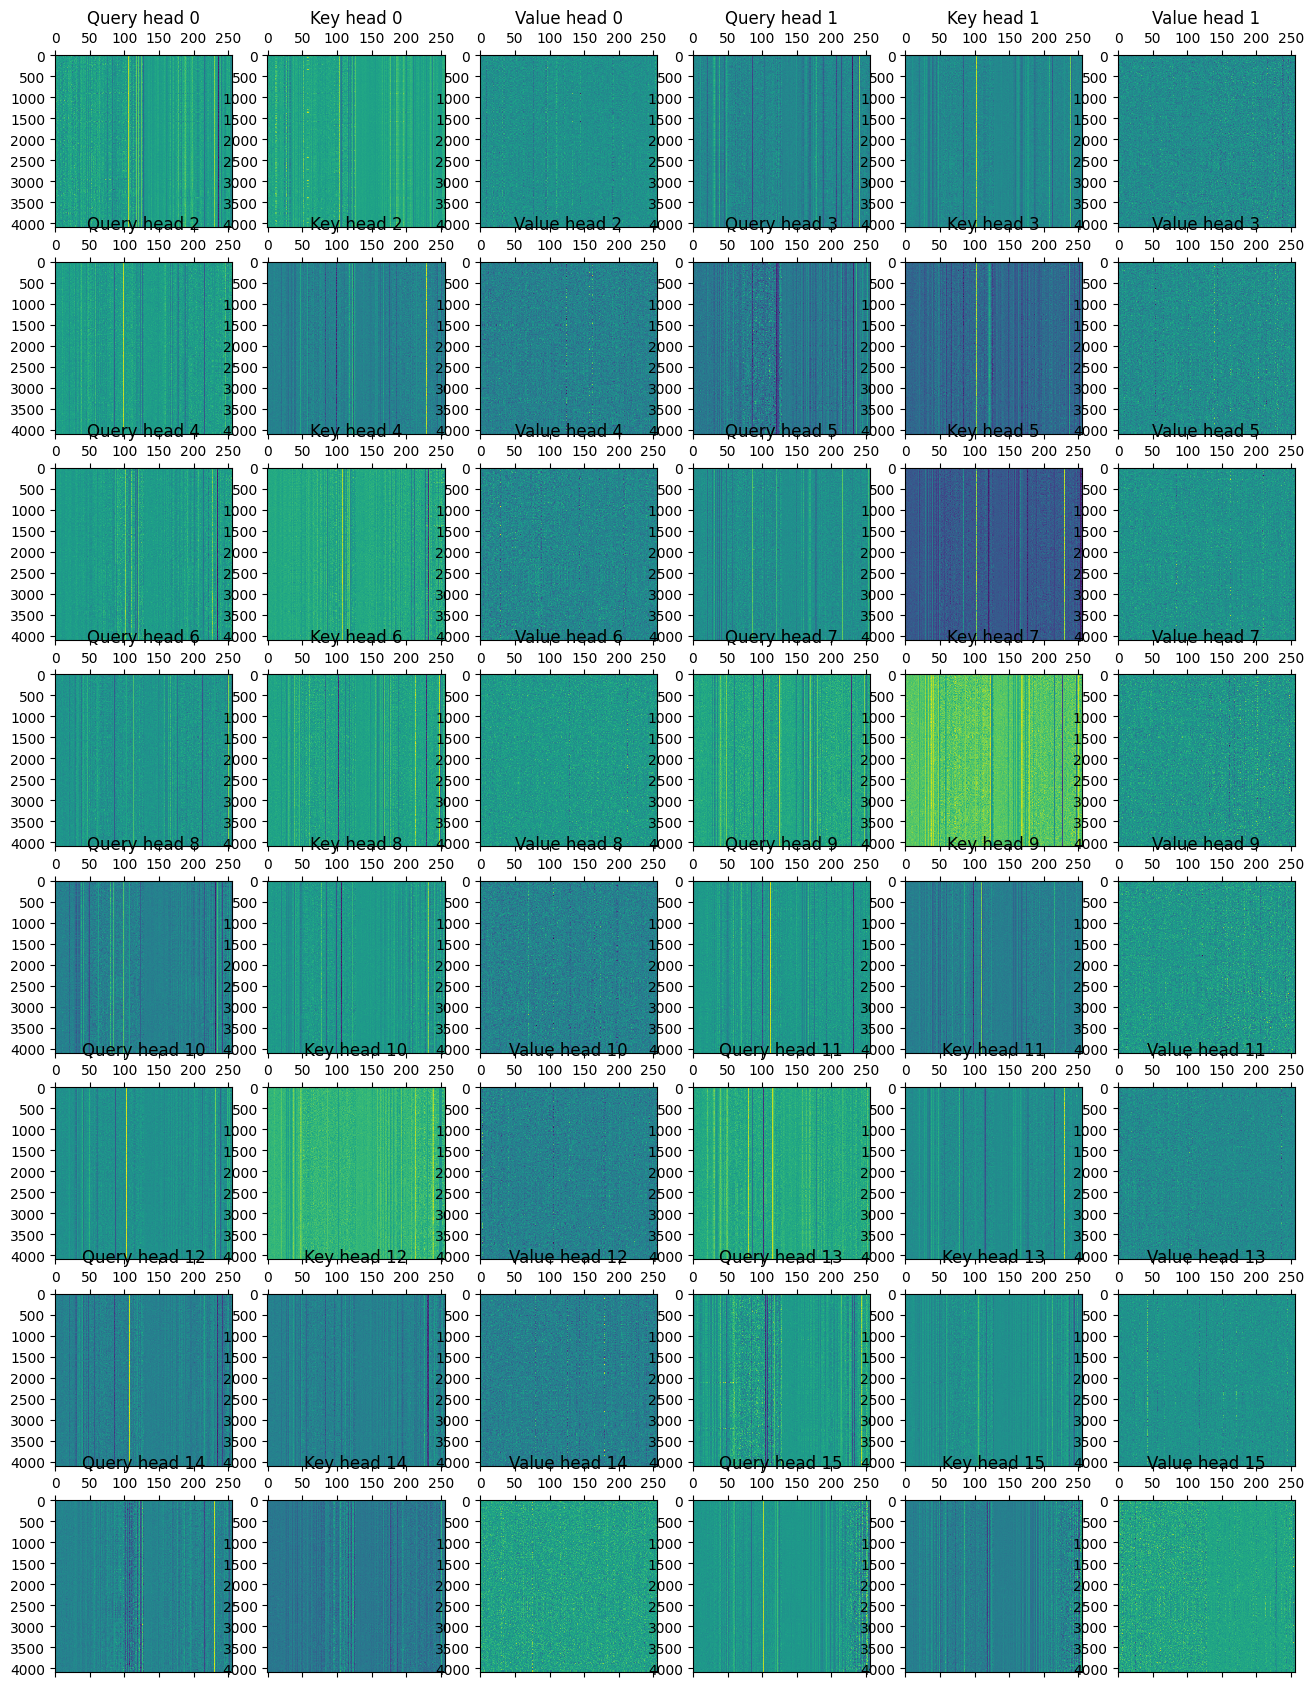

In [7]:
scale = 3*.9
m = 6
n = int(n_heads//2)
fig, axs = plt.subplots(n, m, figsize=(int(scale*m), int(scale*n)))

for pos in range(n_heads*3):
    i,j = divmod(pos, 6)
    h = pos // 3
    if j%3 == 0:
        axs[i,j].matshow(Q[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Query head {h}')
    elif j%3 == 1:
        axs[i,j].matshow(K[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Key head {h}')
    else:
        axs[i,j].matshow(V[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Value head {h}')
plt.show()

In [8]:
Q, K, V = get_qkv(10, block_id, n_heads, quantization_scalars)

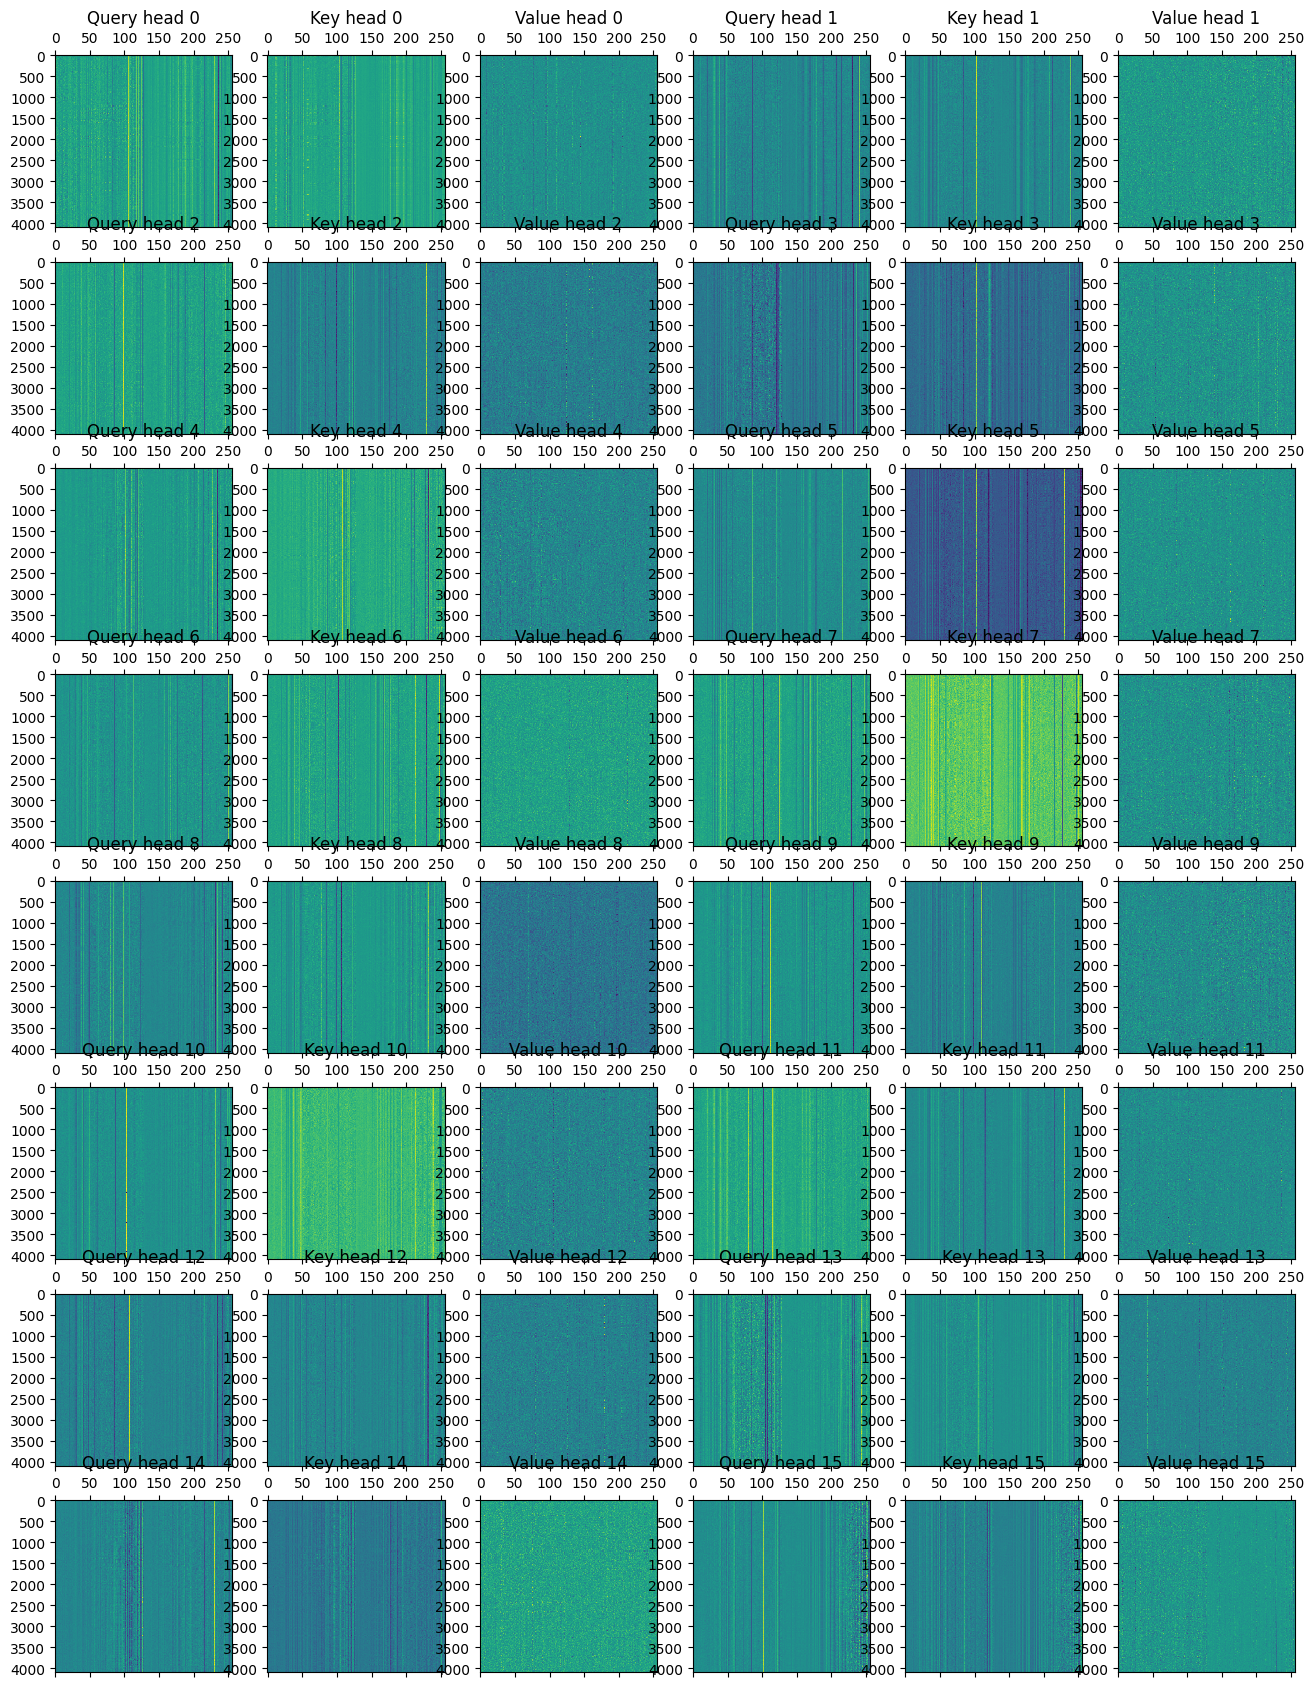

In [9]:
scale = 3*.9
m = 6
n = int(n_heads//2)
fig, axs = plt.subplots(n, m, figsize=(int(scale*m), int(scale*n)))

for pos in range(n_heads*3):
    i,j = divmod(pos, 6)
    h = pos // 3
    if j%3 == 0:
        axs[i,j].matshow(Q[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Query head {h}')
    elif j%3 == 1:
        axs[i,j].matshow(K[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Key head {h}')
    else:
        axs[i,j].matshow(V[h], interpolation ='nearest', aspect='auto')
        axs[i,j].set_title(f'Value head {h}')
plt.show()

In [20]:
lk = []
lq = []
block_id = 3
for i in range(200):
    K = np.load(f'../activations/activations_sample{i}_block{block_id}_attn_proj_k.npy')
    Q = np.load(f'../activations/activations_sample{i}_block{block_id}_attn_proj_q.npy')
    q_nd = quantization_scalars[f'activations_sample{i}_block{block_id}_attn_proj_q.npy']
    k_nd = quantization_scalars[f'activations_sample{i}_block{block_id}_attn_proj_k.npy']
    Q = Q / q_nd
    K = K / k_nd
    lk.append(K.reshape(4096, 4096))
    lq.append(Q.reshape(4096, 4096))
K = np.stack(lk, axis=0); del lk
Q = np.stack(lq, axis=0); del lq

In [21]:
K.shape

(200, 4096, 4096)

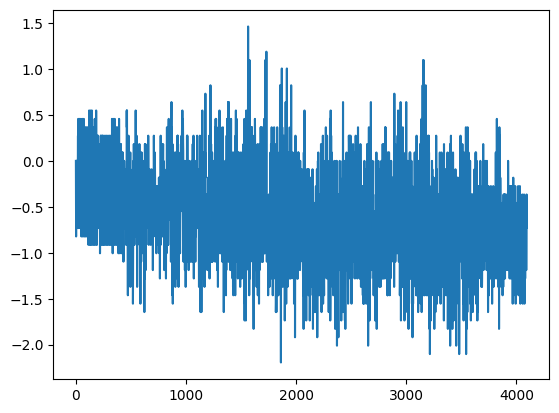

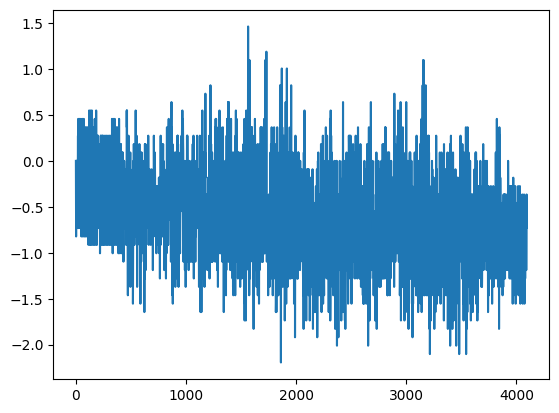

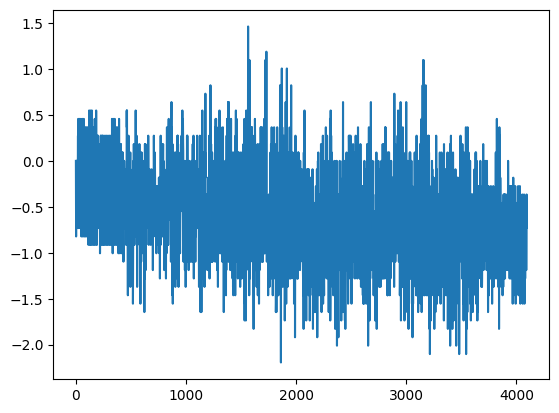

In [29]:
samples = np.random.choice(np.arange(200), size=3, replace=False)
for s in samples:
    x = Q[i,:,10]
    plt.plot(x)
    plt.show()

In [35]:
K.shape

(200, 4096, 4096)

In [37]:
k = K[0]

/tmp/ipykernel_1468808/4139384647.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 100000x100000 with 0 Axes>

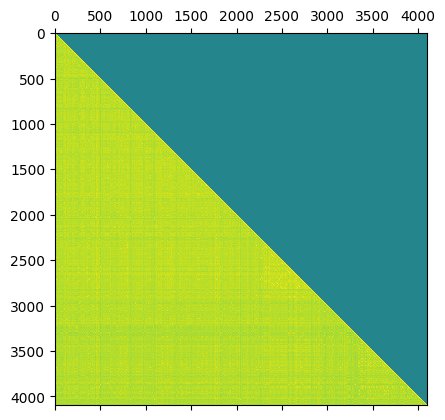

In [88]:
n = np.linalg.norm(k, axis=1)
cosine_sim = np.tril(np.dot(k, k.T) / np.outer(n, n))

plt.figure(figsize=(1000, 1000))
plt.matshow(cosine_sim, interpolation ='nearest', aspect='auto')
plt.tight_layout()
plt.savefig('test.png')
plt.show()

In [67]:
(k@k.T)[:4,:4]

array([[  137.97863079,   165.77986319,  -706.46390412,  -727.26055741],
       [  165.77986319,   226.20159421, -1014.3035785 , -1035.92515122],
       [ -706.46390412, -1014.3035785 ,  7849.74526542,  6326.06116796],
       [ -727.26055741, -1035.92515122,  6326.06116796,  8218.05008763]])

array([11.74643056, 15.03999981, 88.59878817, ..., 89.22407591,
       91.59865462, 96.5332393 ])

In [79]:
np.linalg.norm(k, axis=1)[]

array([11.74643056, 15.03999981, 88.59878817, ..., 89.22407591,
       91.59865462, 96.5332393 ])

In [76]:
k[1]

array([ 0.        ,  0.        ,  0.        , ..., -0.72180451,
       -0.60150376, -0.72180451])

In [77]:
k.T[:,1]

array([ 0.        ,  0.        ,  0.        , ..., -0.72180451,
       -0.60150376, -0.72180451])

In [78]:
np.linalg.norm(k.T[:,1])

15.039999807549586

In [47]:
c

tensor([[-0.1165,  0.2191,  0.1771,  0.0720, -0.1023,  0.2176,  0.0064,  0.1303,
          0.2672,  0.0863],
        [ 0.0280, -0.0527, -0.0426, -0.0173,  0.0246, -0.0523, -0.0015, -0.0313,
         -0.0643, -0.0207],
        [-0.4141,  0.7790,  0.6298,  0.2560, -0.3637,  0.7736,  0.0228,  0.4632,
          0.9500,  0.3067],
        [ 0.2222, -0.4180, -0.3379, -0.1374,  0.1951, -0.4151, -0.0123, -0.2485,
         -0.5098, -0.1645],
        [ 0.2398, -0.4511, -0.3647, -0.1483,  0.2106, -0.4480, -0.0132, -0.2683,
         -0.5502, -0.1776],
        [-0.0207,  0.0388,  0.0314,  0.0128, -0.0181,  0.0386,  0.0011,  0.0231,
          0.0474,  0.0153],
        [ 0.1385, -0.2606, -0.2107, -0.0856,  0.1217, -0.2588, -0.0076, -0.1550,
         -0.3178, -0.1026],
        [-0.4518,  0.8498,  0.6870,  0.2793, -0.3967,  0.8439,  0.0249,  0.5053,
          1.0364,  0.3345],
        [ 0.1189, -0.2236, -0.1808, -0.0735,  0.1044, -0.2221, -0.0066, -0.1330,
         -0.2727, -0.0880],
        [-0.3578,  

In [92]:
x, y = next(iter(ds_train))

In [93]:
tokenizer.decode(x.tolist())

'�q��\x02�\x15\x02&i �\x03a!!\x02�B(h\x06Ip\x04�q�\x1a-\x13�3M\x00&�q�q�q�q�q�q\x13�A�\x133\x0f\x12RU"�S�\x01\x08�q�q�q�qq\x19\x01�]&\x13o\t�q}\x01;\x02�q[\x02pa�\\\x02\x027\x02�\x1a�\x0f\x12RU"�S-7\x1b[\x02pa\r"�Sh\x13�\x133[\x02pa��J2�H�q?��\x0bO�\x19�\x01Y�\x03��\x0b�G��\x00\x0f\x12RU"�S�qy\x0b� \x13o\x03?�\n\x1b\x00\x031\x01�q\n ⁇ \n ⁇ \x1a\x00\x13�SZ2�q�\x01�\x0f�\x1a&mOR\x05N�\x19-7\x1b�\x0eY\x02�q}\x01;\x02�q\x04R�\x05�S�\x1a�q�o}\x0b�-7\x1bo}\x0b�\x04\x04R�%�q\x04�J2k\x0c�qcJ�q\x14\x03Y\x04�q��\x01�\x0f�l�\x02q\x05�\\g�q�\x0b�q-7\x1b���q\n ⁇ \n ⁇ �&�\x0f\x0b�\x0c\x15\x02-\x12\nIQ?�\x00\x07\x01X\x04 \x00\x00\x037\x02&\x04^\x04�\x08��\x134\x04�q}\x07_\x01l\x15\x02�~�jmp&\x043\x1c�\x08Y?�q!\x02�\x0f\x12RU"�S&\x04\x14\x03Y?�q\n ⁇ \n ⁇ \x1a\x00�"\n ⁇ \n ⁇ �q�\x14"�SO~\x01\r@\r3\x06\x00�9\x15\x02�"�q��s�\x05\x1c\x1b�\x0e\x08?\x01\x08\x1f�q�D\x1a�O?�E6\x04q\x00�\x03�\x01�\x0f�qfP�\x05�SO�\x05&�\x01\x18�q�}\x0b?�\x00n\x1a�:\x1a�O�q�!\x19"�SO�\x05&3\x16�L�q�\'��q?�\x18&\x14\x03Z\x01�\x0

In [98]:
ar = np.memmap('data/train.bin', dtype=np.uint16, mode='r')

In [99]:
tokenizer.decode(ar[:4].tolist())

'The American Library Association'

In [224]:
res = 0
for i in range(n):
    for j in range(n):
        res += x[i]*x[j]*z[i]*z[j]
res

0.09790697272742185

In [222]:
x

array([-0.6427633 ,  0.64751949])

In [20]:
math.exp(1)/sum([math.exp(1), math.exp(6), math.exp(3)])

0.006377460922442297

In [304]:
L = torch.nn.Linear(124, 16)
lmbda = 1

In [305]:
x = torch.randn(1, 124)

In [306]:
U = dist.Uniform(0, 1)
G = dist.Gumbel(0, 1)
gumbel_transform = lambda u: - torch.log( - torch.log(u))

In [307]:
g = G.sample(sample_shape=(16,))


In [308]:
g.shape

torch.Size([16])

In [309]:
a = L(x)

In [310]:
a

tensor([[ 0.3046, -0.6786, -0.5013,  1.1889, -1.2514, -0.2266,  0.8777, -0.7108,
         -1.0188,  0.3205,  0.9372,  0.1740, -0.1202,  0.6434, -0.4213,  1.0999]],
       grad_fn=<AddmmBackward0>)

In [311]:
y = F.softmax((a.requires_grad_(True) + g.unsqueeze(0)) / lmbda, dim=-1)

In [312]:
y

tensor([[3.3541e-02, 4.0573e-04, 7.4320e-04, 2.1877e-02, 5.7568e-02, 3.7437e-02,
         1.9383e-03, 1.4514e-02, 3.1444e-04, 1.9065e-03, 4.6129e-03, 2.3255e-03,
         3.5822e-03, 8.1414e-01, 1.1174e-03, 3.9777e-03]],
       grad_fn=<SoftmaxBackward0>)

In [313]:
y.sum().backward()

In [314]:
L.weight.grad.sum()

tensor(-1.2199e-06)

<BarContainer object of 16 artists>

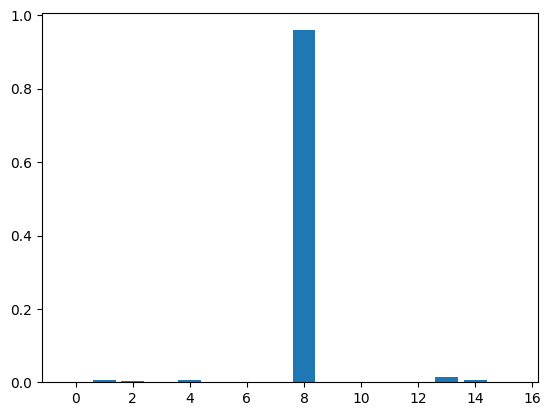

In [26]:
plt.bar(x = np.arange(y.numel()), height = y.squeeze().detach().numpy())

In [316]:
y.max()

tensor(0.8141, grad_fn=<MaxBackward1>)

In [25]:
y.numel()

16

In [38]:
import numpy as np
import pickle

In [32]:
d = {'a': np.random.randn(2,2), 'b': np.random.randn(3,3)}

In [34]:
np.save('test.npy', d)

In [35]:
x = np.load('test.npy', allow_pickle=True)

In [39]:
with open('test.npy', 'wb') as f:
    pickle.dump(d, f)

In [40]:
with open('test.npy', 'rb') as f:
    d = pickle.load(f)

In [41]:
d

{'a': array([[ 0.62360775,  0.6940674 ],
        [-0.68902921, -0.38595602]]),
 'b': array([[ 0.03127388,  0.55495369, -0.16248388],
        [ 0.40091705,  0.90416002,  0.21716094],
        [-0.31784587,  0.79398917,  0.46987025]])}